In [3]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import*
import scipy.optimize as opt
from tcsim.analyze.dataloader import*
from tcsim.analyze.fit_funcs.char_func_cat import char_func_cat

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp2d

In [4]:
def load_data_no_average(path: str, file_end: str, plot = True): 
    """_summary_

    Args:
        path (str): folder where files are located
        file_end (str): ending of files to load
        
    Returns:
        dd (dict): keys are time stamps and value is a non averaged data set of size (number of total reps, x, y)
    """
    fps = []
    fp = [path + f for f in os.listdir(path) if f.endswith(file_end)]
    fps = np.concatenate([fp[:]])
    
    dg = []
    de = []
    dts = []
    for kk in range(len(fps)):
        df = h5py.File(fps[kk], "r")
        data = df["data"]
        data_i = data["I"][:]
        x = data["x"][:, 0, 0]
        y = data["y"][0, :, 0]
        dt = df.attrs['decay_time']
        thresh = -6.687025253601604e-06
#         ss_data = np.where(data_i < thresh, 1, 0)
#         thresh_1 = 6.30337300715842e-05
        raw_m0 = data_i[:, 0::3]
        raw_m1 = data_i[:, 1::3] 
        raw_m2 = data_i[:, 2::3]
        
        m0 = np.where(raw_m0 < thresh, 1, 0)
        m1 = np.where(raw_m1 < thresh, 1, 0)
        m2 = np.where(raw_m2 < thresh, 1, 0)
        
        m1_g = ma.masked_array(m1, mask=m0)
        m2_g = ma.masked_array(m2, mask=m0)
        ## I only care about the double selected data!
        ## I use filled to replace all masked arrays with nan. This allows me to not care about masks after this point. This is useful, as i can later use np.nanmean to calculate the mean value.
        double_ps_g = ma.masked_array(m2_g, mask=m1_g, dtype='float').filled(np.nan).reshape(df.attrs["reps"],len(x), len(y)) * 2 - 1
        double_ps_e = ma.masked_array(m2_g, mask=np.logical_not(m1_g), dtype='float').filled(np.nan).reshape(df.attrs["reps"], len(x), len(y)) * 2 - 1
        dg.append(double_ps_g)
        de.append(double_ps_e)
        dts.append(dt)

    dg = np.array(dg)
    de = np.array(de)
    dts = np.array(dts)
    decay_times = np.unique(dts)

    
    dd = {}
    # initialize a dictionary with decay times as keys
    for n in range(len(decay_times)):
            dd[str(decay_times[n])] = []

    # use dts to sort the values by decay time into the correct bin
    for n, dt in enumerate(dts):
        dd[str(dt)].append(dg[n])
      
    # stack all arrays that were in the list
    for dt in decay_times:
        dd[str(dt)] = np.vstack(np.array(dd[str(dt)]))
    
    rows = 1
    cols = len(decay_times)
    fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
    # for i in range(rows):
    for j in range(cols):
        
        axes[j].pcolormesh(x, x, np.nanmean(dd[str(decay_times[j])][:, :], axis = 0), cmap="seismic", shading = 'auto', vmax=1, vmin=-1)
        axes[j].set_aspect("equal")
        axes[j].set_title(str(decay_times[j]))     
    plt.show()
    return dd, decay_times, x, y 
    
def bootstrap_resample(X):
    n = shape(X)[0]
    X_resample = np.zeros_like(X.T)
    XT = X.T.copy()

    resample_i = np.floor(np.random.rand(n)*n).astype(int)
    for x in range(shape(X)[1]):
        for y in range(shape(X)[2]):
                      
                X_resample[:][y][x] = XT[y][x][resample_i]
    return X_resample.T
    
def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2

def cut_indexes(y_inter,angle):
    k = np.tan(angle)
    max_y_index = np.max(y_inter) # define maximal y_index allowed
    max_x_index = max_y_index
    xvec_fine = np.linspace(0, max_x_index, len(y_inter))
    for i, x in enumerate(xvec_fine):
        if np.abs(x*k)>max_y_index:
            max_x_index = xvec_fine[i-1]
            break
    x_indicies = np.linspace(-max_x_index, max_x_index, len(y_inter))
    y_indicies = x_indicies*k
    return x_indicies, y_indicies
    


def gauss_1(x, amp1, cen1, sigma1):
    return amp1 * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2)))

def gauss_3(x, amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3):
    """ Fitting Function"""
    return amp1 * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2))) + \
           amp2 * (np.exp((-1.0 / 2.0) * (((x - cen2) / sigma2) ** 2))) + \
           amp3 * (np.exp((-1.0 / 2.0) * (((x - cen3) / sigma3) ** 2)))

In [2]:
## retired, but kept for safety for now

# quick comment on plot error handling. introduced flag that is set to true if there is a plotting error. this will result in skipping the rest of the code and the reptition in which the error happend is not taken into account.


def extract_blob_amplitudes_bootstrap(dd, decay_times, x, y, n_reps, plot=False, bootstrap=True, p0_angles =[0, 0, 0, 0, 0, 0, 0,0,0,0],initial_guess_3gaussian = [0,0,0,0,0,0,0,0,0], bounds =([-np.inf, -3.5, -np.inf,-np.inf, -np.inf, -0.9,-np.inf, 2.5, -np.inf ],[np.inf,-2.5, 1.2,np.inf, np.inf, 1.2,np.inf, 3.5, 1.1 ])):
    blob_amps = {}
        # initialize a dictionary with decay times as keys
    for n in range(len(decay_times)):
            blob_amps[str(decay_times[n])] = []
            
    blob_angle = {}
        # initialize a dictionary with decay times as keys
    for n in range(len(decay_times)):
            blob_angle[str(decay_times[n])] = []

    data_dict = dd
    for rep in range(n_reps):
        plot_error = False
        temp_blob_angle = blob_angle
        if bootstrap:
            dd_bt = {}
            # resample data and saved resampled data in new dictionary
            for j in range(len(decay_times)):
                dd_bt[str(decay_times[j])] = bootstrap_resample(dd[str(decay_times[j])])
            data_dict = dd_bt
        
        if plot:
            fig, axs = plt.subplots(2, len(decay_times), sharey="row", sharex="col", figsize = (20,10))
            gs1 = gridspec.GridSpec(2, len(decay_times))
            gs1.update(wspace=0.025, hspace=0.05)

        p0_angles = p0_angles
        popts = []
        angles = []
        print("Run Number:", rep)
        for i, time in enumerate(decay_times):
            
            scaling = 3
            xvec = x*scaling # i define it like this in case i want to slice x
            yvec = x*scaling
            X, Y = np.meshgrid(yvec, xvec)

            #(xy_tuple, amplitude, sigma_x, sigma_y, beta_amp, theta, offset)
            initial_guess = (0.8,  0.8, 1, 1, p0_angles[i], -0.08301675) # upper blob
            data = np.nanmean(data_dict[str(decay_times[i])], axis = 0)
            try:
                popt, pcov = opt.curve_fit(char_func_cat, (X, Y), data.flatten(), p0=initial_guess, maxfev = 5000)
                popts.append(popt)
                angles.append(popt[4])
                blob_angle[str(time)].append(popt[4])

                data_fitted1 = char_func_cat((X, Y), *popt)
                if plot:
                    axs[0][i].pcolormesh(X,Y, data, cmap="seismic", vmin = -1 , vmax = 1)
                    axs[0][i].contour(yvec,xvec, data_fitted1.reshape(X.shape))
                    axs[0][i].set_aspect("equal")
                    axs[0][i].set_title(str(decay_times[i]))
                    
            except RuntimeError:
                print(f"Runtime Error occured trying to fit cat in repetition {rep} for time {time}. Move on to next repetition")
                plot_error = True

    
        
        
        if not plot_error:
            cut_array = []
            for i, time in enumerate(decay_times):
                data = np.nanmean(data_dict[str(decay_times[i])], axis = 0)
                angle = angles[i]
                if np.abs(angles[i])<np.deg2rad(15):
                    data =  np.nanmean(data_dict[str(decay_times[i])], axis = 0).T
                    angle = np.pi/2-angles[i]
                #interpolate data
                func = interp2d(xvec,yvec,data, kind="cubic")
                # define finer x,y arrays with same end values as data x,y
                x_inter = np.linspace(np.min(xvec),np.max(xvec), 2000)
                y_inter = np.linspace(np.min(xvec),np.max(xvec), 2000)
                
                # get x and y indicies for line cut and load the line cut in cut
                x_index, y_index = cut_indexes(y_inter, np.pi/2-angle)
                cut = []
                for j in range(len(x_index)):
                    cut.append(float(func(x_index[j],y_index[j])))
                cut_array.append(cut)
                if plot:
                    axs[1][i].set_aspect("equal")
                    axs[1][i].pcolormesh(x_inter, y_inter, func(x_inter,x_inter), vmin=-1, vmax=1 , cmap="seismic")
                    axs[1][i].scatter(x_index, y_index, c='k', marker = '.')
            
            plt.tight_layout()

            
            fit_amp_cat = []
            fit_amp_std_cat = []
            fig2, axs2 = plt.subplots(len(decay_times),1)  
            
            for i, cut in enumerate(cut_array):
                
                
                x_cut = np.array(x_inter)
                y_cut = np.array(cut)
                
                y0 = gauss_3(x, *initial_guess_3gaussian)

                try:
                    popt, pcov = curve_fit(gauss_3, x_cut, y_cut, p0=initial_guess_3gaussian, bounds=bounds,maxfev = 5000)
                    blob_amps[str(decay_times[i])].append((popt[0]+popt[6])/2)
                    if plot: 
                        axs2[i].plot(x_cut, y_cut, 'b', label="given curve")
                        axs2[i].plot(x_cut, gauss_3(x_cut, *popt), ls=':', label="Fit function", linewidth=4, color='purple')
                        for j, (a, c, s )in enumerate( popt.reshape(-1, 3)):
                            axs2[i].plot(x_cut, gauss_1(x_cut, a, c, s), ls='-', label=f"gauss {j+1}", linewidth=1, color='crimson')
                        #axs2[i].legend()
                        #axs2[i].autoscale(axis='x', tight=True)
            
                
                except RuntimeError:
                    print(f"RuntimeError ocurred during triple gaussian fit in rep {rep} for time{decay_times[i]}" )
                    plot_error = True
                    blob_angle = temp_blob_angle # forget any change done to blob angle in this round
                    continue
    if plot:
            plt.tight_layout()
            plt.show()
               
    return blob_amps, blob_angle


# only use this function if n_reps is high enough! might lead to error for lower values
# filtering out data with wrong fitting angle
def find_averaged_amps_and_errorbars(decay_times, blob_amps, blob_angle):
    blob_amps_averaged = []
    error_bars = []
    for time in decay_times:
        blobbies = np.array(blob_amps[str(time)])
        blobbies = blobbies[blobbies<0.5] # filter all blobs with amp larger 0.5, as they are unphysical and plotting errors.
        # # make sure angles has same length as blob_amps for every time
        # angles = np.array(blob_angle[str(time)])[:len(blob_amps[str(time)])]
        # # only keep the blob_amp values, for which the angle is withhin one std of the mean angle value. 
        # blobbies[str(time)] = np.array(blob_amps[str(time)])[np.abs((angles-np.mean(angles)))<np.std(angles)]
        
        blob_amps_averaged.append(np.mean(blobbies))
        error_bars.append(np.std(blobbies))
        
    return blob_amps_averaged, error_bars

        

NameError: name 'np' is not defined

In [12]:
# quick comment on plot error handling. introduced flag that is set to true if there is a plotting error. this will result in skipping the rest of the code and the reptition in which the error happend is not taken into account.


def extract_blob_amplitudes_bootstrap(dd, decay_times, x, y, n_reps, plot=False, p0_angles =[0, 0, 0, 0, 0, 0, 0,0,0,0],initial_guess_3gaussian = [0,0,0,0,0,0,0,0,0], bounds =([-np.inf, -3.5, -np.inf,-np.inf, -np.inf, -0.9,-np.inf, 2.5, -np.inf ],[np.inf,-2.5, 1.2,np.inf, np.inf, 1.2,np.inf, 3.5, 1.1 ])):
    
    data_dict = dd
    ### Initialize two dictionaries that will be filled up and return in the end
    blob_amps = {}
    blob_angle = {}
        # initialize a dictionary with decay times as keys
    for n in range(len(decay_times)):
            blob_amps[str(decay_times[n])] = []
            blob_angle[str(decay_times[n])] = []

    # do the boostraping, n_rep times
    for rep in range(n_reps):
        
        ### 0. resample data and saved resampled data in new dictionary
        dd_bt = {}
        for j in range(len(decay_times)):
            dd_bt[str(decay_times[j])] = bootstrap_resample(dd[str(decay_times[j])])
        data_dict = dd_bt
        
        ### 1. Find the angles by fitting functionl cat form to the experimental data
        p0_angles = p0_angles
        popts_cat = []
        angles = []
        print("Run Number:", rep)
        for i, time in enumerate(decay_times):
            
            scaling = 3
            xvec = x*scaling # i define it like this in case i want to slice x
            yvec = x*scaling
            X, Y = np.meshgrid(yvec, xvec)

            #(xy_tuple, amplitude, sigma_x, sigma_y, beta_amp, theta, offset)
            initial_guess = (0.8,  0.8, 1, 1, p0_angles[i], -0.08301675) # upper blob
            data = np.nanmean(data_dict[str(decay_times[i])], axis = 0)
            
            popt, pcov = opt.curve_fit(char_func_cat, (X, Y), data.flatten(), p0=initial_guess, maxfev = 5000)
            popts_cat.append(popt)
            angles.append(popt[4])
            blob_angle[str(time)].append(popt[4])

        ### 2. Use the angles to make a line cut
        cut_array = []
        popts_3gaussian = []
        ### 2.1 Fill up cut_array with the individual cuts
        for i, time in enumerate(decay_times):
            data = np.nanmean(data_dict[str(decay_times[i])], axis = 0)
            angle = angles[i]
            if np.abs(angles[i])<np.deg2rad(15):
                data =  np.nanmean(data_dict[str(decay_times[i])], axis = 0).T
                angle = np.pi/2-angles[i]
            #interpolate data
            func = interp2d(xvec,yvec,data, kind="cubic")
            # define finer x,y arrays with same end values as data x,y
            x_inter = np.linspace(np.min(xvec),np.max(xvec), 2000)
            y_inter = np.linspace(np.min(xvec),np.max(xvec), 2000)
            
            # get x and y indicies for line cut and load the line cut in cut
            x_index, y_index = cut_indexes(y_inter, np.pi/2-angle)
            cut = []
            for j in range(len(x_index)):
                cut.append(float(func(x_index[j],y_index[j])))
            cut_array.append(cut)
            
        ### plot 3 gaussians to each cut in cut_array
        for i, cut in enumerate(cut_array):
            x_cut = np.array(x_inter)
            y_cut = np.array(cut)

            popt, pcov = curve_fit(gauss_3, x_cut, y_cut, p0=initial_guess_3gaussian, bounds=bounds,maxfev = 5000)
            popts_3gaussian.append(popt)
            blob_amps[str(decay_times[i])].append((popt[0]+popt[6])/2)
                
            
                

        if plot:
            fig, axs = plt.subplots(1, len(decay_times), sharey="row", sharex="col", figsize = (20,10))
            for i, time in enumerate(decay_times):
                
                data_fitted1 = char_func_cat((X, Y), *popts_cat[i])
                axs[i].set_aspect("equal")
                axs[i].pcolormesh(X,Y, data, cmap="seismic", vmin = -1 , vmax = 1)
                axs[i].contour(yvec,xvec, data_fitted1.reshape(X.shape))

                axs[i].set_title(str(decay_times[i]))
            plt.tight_layout()
            plt.show()
            
            fig, axs = plt.subplots( len(decay_times),1, sharey="row", sharex="col", figsize = (10,20))
            for i, cut in enumerate(cut_array):
                axs[i].plot(x_cut, np.array(cut), 'b', label="given curve")
                axs[i].plot(x_cut, gauss_3(x_cut, *popts_3gaussian[i]), ls=':', label="Fit function", linewidth=4, color='purple')
                for j, (a, c, s )in enumerate( popts_3gaussian[i].reshape(-1, 3)):
                    axs[i].plot(x_cut, gauss_1(x_cut, a, c, s), ls='-', label=f"gauss {j+1}", linewidth=1, color='crimson')
            #axs2[i].legend()
            #axs2[i].autoscale(axis='x', tight=True)
            plt.tight_layout()
            plt.show()
               
    return blob_amps, blob_angle


# only use this function if n_reps is high enough! might lead to error for lower values
# filtering out data with wrong fitting angle
def find_averaged_amps_and_errorbars(decay_times, blob_amps, blob_angle):
    blob_amps_averaged = []
    error_bars = []
    for time in decay_times:
        blobbies = np.array(blob_amps[str(time)])
        blobbies = blobbies[blobbies<0.5] # filter all blobs with amp larger 0.5, as they are unphysical and plotting errors.
        # # make sure angles has same length as blob_amps for every time
        # angles = np.array(blob_angle[str(time)])[:len(blob_amps[str(time)])]
        # # only keep the blob_amp values, for which the angle is withhin one std of the mean angle value. 
        # blobbies[str(time)] = np.array(blob_amps[str(time)])[np.abs((angles-np.mean(angles)))<np.std(angles)]
        
        blob_amps_averaged.append(np.mean(blobbies))
        error_bars.append(np.std(blobbies))
        
    return blob_amps_averaged, error_bars

        

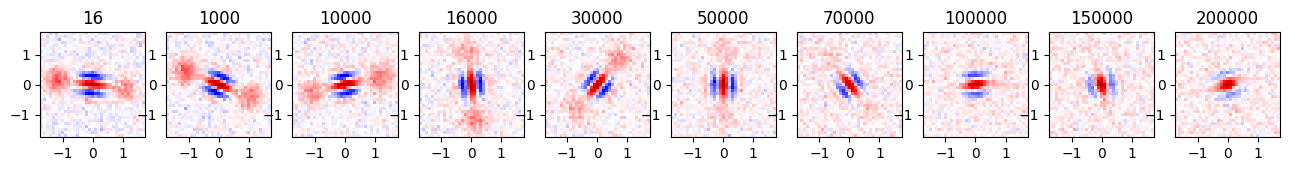

Run Number: 0


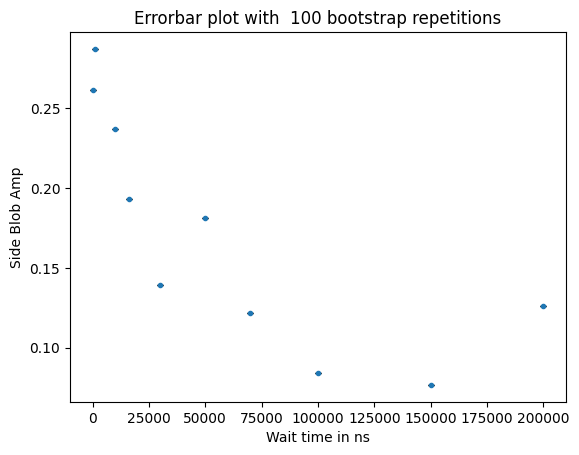

In [13]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data/"
file_end = 'cat_decay.h5'
dd, decay_times, x, y = load_data_no_average(path, file_end)

amp1 = 0.4
sigma1 = 1
cen1 = -3.6
amp2 = 0.8
sigma2 = 1
cen2 = 0
amp3 = 0.4
cen3 = 3.6
sigma3 = 1      
initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
angles = [1.68, 1.96, 1.35, 3.02, 0.68, 3.16, 2.465, 1.47, 2.97, 1.16]

bounds =([0, -5, 0.2 ,0, -0.5, 0.2 ,0,2.5, 0.2],
[0.5, 5, 1 ,1, 0.5, 1.1 ,0.5, 5, 1])


for i in range(1):
    cat_blob_amps, cat_blob_angle = extract_blob_amplitudes_bootstrap(dd, decay_times, x, y, 1, p0_angles=angles, initial_guess_3gaussian=initial_guess, plot=False, bounds=bounds)

    cat_blob_amps_averaged , cat_error_bars = find_averaged_amps_and_errorbars(decay_times, cat_blob_amps, cat_blob_angle)

    plt.errorbar(decay_times[:], cat_blob_amps_averaged[:],yerr=cat_error_bars[:],fmt= '.', ecolor = 'k', capsize = 2)
    plt.title(f'Errorbar plot with  100 bootstrap repetitions')
    plt.xlabel('Wait time in ns')
    plt.ylabel("Side Blob Amp")

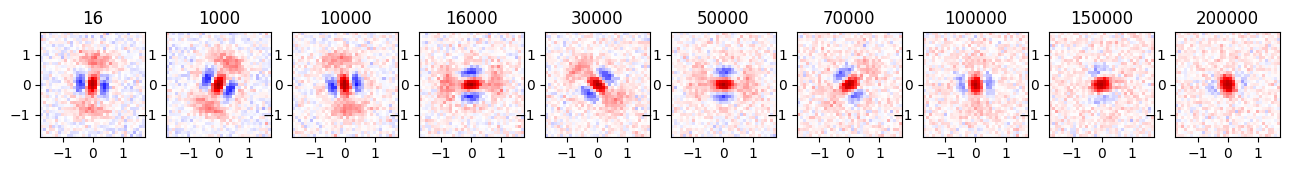

Run Number: 0
Run Number: 1
Run Number: 2
Run Number: 3
Run Number: 4
Run Number: 5
Run Number: 6
Run Number: 7
Run Number: 8
Run Number: 9
Run Number: 10
Run Number: 11
Run Number: 12
Run Number: 13
Run Number: 14
Run Number: 15
Run Number: 16
Run Number: 17
Run Number: 18
Run Number: 19
Run Number: 20
Run Number: 21
Run Number: 22
Run Number: 23
Run Number: 24
Run Number: 25
Run Number: 26
Run Number: 27
Run Number: 28
Run Number: 29
Run Number: 30
Run Number: 31
Run Number: 32
Run Number: 33
Run Number: 34
Run Number: 35
Run Number: 36
Run Number: 37
Run Number: 38
Run Number: 39
Run Number: 40
Run Number: 41
Run Number: 42
Run Number: 43
Run Number: 44
Run Number: 45
Run Number: 46
Run Number: 47
Run Number: 48
Run Number: 49
Run Number: 50
Run Number: 51
Run Number: 52
Run Number: 53
Run Number: 54
Run Number: 55
Run Number: 56
Run Number: 57
Run Number: 58
Run Number: 59
Run Number: 60
Run Number: 61
Run Number: 62
Run Number: 63
Run Number: 64
Run Number: 65
Run Number: 66
Run N

Text(0, 0.5, 'Side Blob Amp')

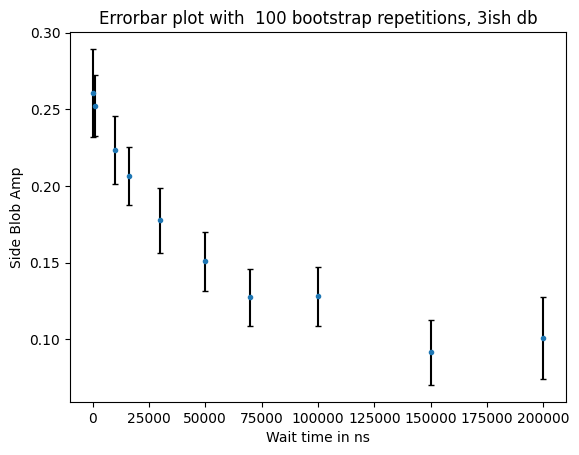

In [13]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data/"
file_end = '3db.h5'
dd, decay_times, x, y = load_data_no_average(path, file_end)

amp1 = 0.4
sigma1 = 0.6
cen1 = -3
amp2 = 0.8
sigma2 = 1
cen2 = 0
amp3 = 0.25
cen3 = 3
sigma3 = 0.6      
initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
angles_3db = [0.14, 3.58, -0.16, 1.54, -0.82, 1.6, 0,-0.04, 1.5, -0.28]

bounds =([-0, -3.1, 0.3, 0, -np.inf, 0.5,0, 2.5, 0.3 ],
         [np.inf,-1.5, 0.7 ,np.inf, np.inf, 1,np.inf, 3.1, 0.7])

bounds =([0, -5, 0.2 ,0, -0.5, 0.2 ,0,2.5, 0.2],
[0.5, 5, 1 ,1, 0.5, 1.1 ,0.5, 5, 1])

db3_blob_amps, db3_blob_angle = extract_blob_amplitudes_bootstrap(dd, decay_times, x, y, 100, p0_angles=angles_3db, initial_guess_3gaussian=initial_guess, plot=False, bounds=bounds)

db3_blob_amps_averaged , db3_error_bars = find_averaged_amps_and_errorbars(decay_times, db3_blob_amps, db3_blob_angle)

plt.errorbar(decay_times[:], db3_blob_amps_averaged[:],yerr=db3_error_bars,fmt= '.', ecolor = 'k', capsize = 2)
plt.title(f'Errorbar plot with  100 bootstrap repetitions, 3ish db')
plt.xlabel('Wait time in ns')
plt.ylabel("Side Blob Amp")


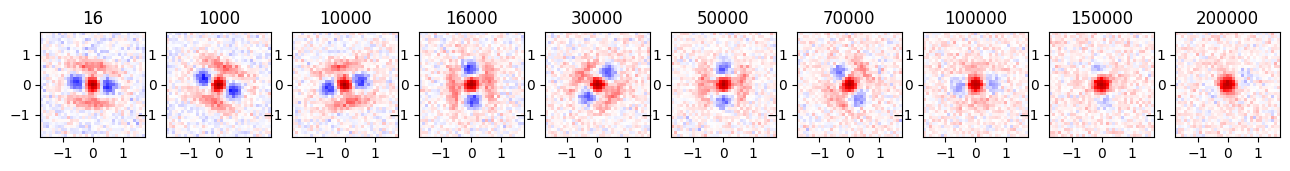

Run Number: 0
Run Number: 1
Run Number: 2
Run Number: 3
Run Number: 4
Run Number: 5
Run Number: 6
Run Number: 7
Run Number: 8
Run Number: 9
Run Number: 10
Run Number: 11
Run Number: 12
Run Number: 13
Run Number: 14
Run Number: 15
Run Number: 16
Run Number: 17
Run Number: 18
Run Number: 19
Run Number: 20
Run Number: 21
Run Number: 22
Run Number: 23
Run Number: 24
Run Number: 25
Run Number: 26
Run Number: 27
Run Number: 28
Run Number: 29
Run Number: 30
Run Number: 31
Run Number: 32
Run Number: 33
Run Number: 34
Run Number: 35
Run Number: 36
Run Number: 37
Run Number: 38
Run Number: 39
Run Number: 40
Run Number: 41
Run Number: 42
Run Number: 43
Run Number: 44
Run Number: 45
Run Number: 46
Run Number: 47
Run Number: 48
Run Number: 49
Run Number: 50
Run Number: 51
Run Number: 52
Run Number: 53
Run Number: 54
Run Number: 55
Run Number: 56
Run Number: 57
Run Number: 58
Run Number: 59
Run Number: 60
Run Number: 61
Run Number: 62
Run Number: 63
Run Number: 64
Run Number: 65
Run Number: 66
Run N

Text(0, 0.5, 'Side Blob Amp')

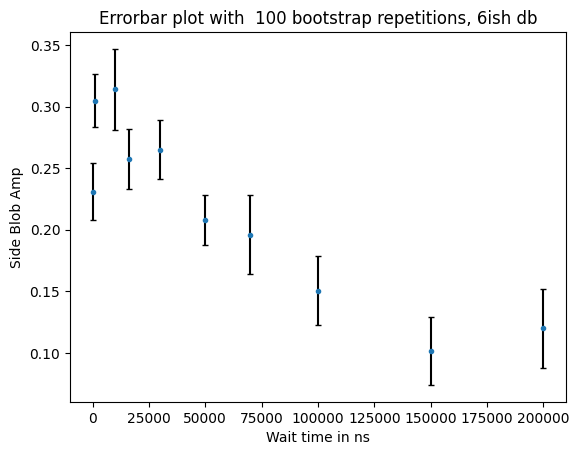

In [16]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data/"
file_end = '6db.h5'
dd, decay_times, x, y = load_data_no_average(path, file_end)

amp1 = 0.4
sigma1 = 0.45
cen1 = -2.1
amp2 = 0.8
sigma2 = 1
cen2 = 0
amp3 = 0.4
cen3 = 2.1
sigma3 = 0.45      
initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
angles_6db = [0.09, 0.36, -0.27, 1.41, -0.91, 1.5, 0.863, -0.1, 1.32, -0.43]

bounds =([0, -5, 0.2 ,0, -0.5, 0.2 ,0,0, 0.2],
[0.5, 0, 1 ,1, 0.5, 1.1 ,0.5, 5, 1])


db6_blob_amps, db6_blob_angle = extract_blob_amplitudes_bootstrap(dd, decay_times, x, y, 100, p0_angles=angles_6db, initial_guess_3gaussian=initial_guess, plot=False, bounds=bounds)

db6_blob_amps_averaged , db6_error_bars = find_averaged_amps_and_errorbars(decay_times, db6_blob_amps, db6_blob_angle)

plt.errorbar(decay_times[:], db6_blob_amps_averaged[:],yerr=db6_error_bars,fmt= '.', ecolor = 'k', capsize = 2)
plt.title(f'Errorbar plot with  100 bootstrap repetitions, 6ish db')
plt.xlabel('Wait time in ns')
plt.ylabel("Side Blob Amp")


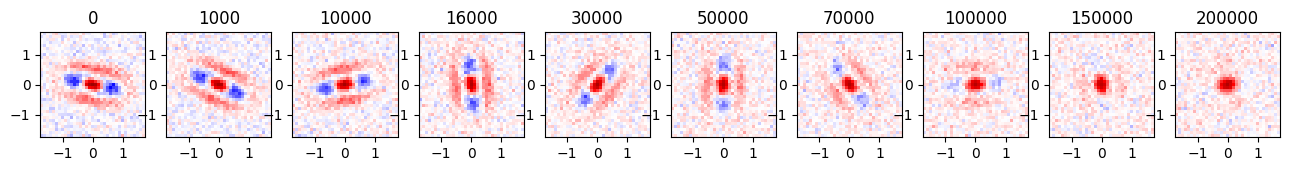

Run Number: 0
Run Number: 1
Run Number: 2
Run Number: 3
Run Number: 4
Run Number: 5
Run Number: 6
Run Number: 7
Run Number: 8
Run Number: 9
Run Number: 10
Run Number: 11
Run Number: 12
Run Number: 13
Run Number: 14
Run Number: 15
Run Number: 16
Run Number: 17
Run Number: 18
Run Number: 19
Run Number: 20
Run Number: 21
Run Number: 22
Run Number: 23
Run Number: 24
Run Number: 25
Run Number: 26
Run Number: 27
Run Number: 28
Run Number: 29
Run Number: 30
Run Number: 31
Run Number: 32
Run Number: 33
Run Number: 34
Run Number: 35
Run Number: 36
Run Number: 37
Run Number: 38
Run Number: 39
Run Number: 40
Run Number: 41
Run Number: 42
Run Number: 43
Run Number: 44
Run Number: 45
Run Number: 46
Run Number: 47
Run Number: 48
Run Number: 49
Run Number: 50
Run Number: 51
Run Number: 52
Run Number: 53
Run Number: 54
Run Number: 55
Run Number: 56
Run Number: 57
Run Number: 58
Run Number: 59
Run Number: 60
Run Number: 61
Run Number: 62
Run Number: 63
Run Number: 64
Run Number: 65
Run Number: 66
Run N

Text(0, 0.5, 'Side Blob Amp')

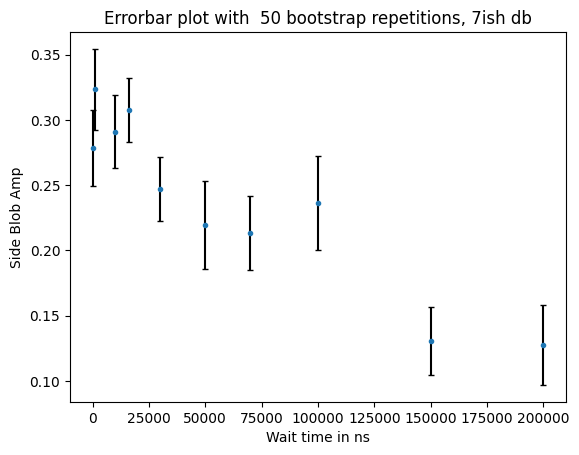

In [17]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data/"
file_end = '7db.h5'
dd, decay_times, x, y = load_data_no_average(path, file_end)

amp1 = 0.4
sigma1 = 0.32
cen1 = -1.5
amp2 = 0.8
sigma2 = 1
cen2 = 0
amp3 = 0.4
cen3 = 1.5
sigma3 = 0.32     
initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
angles_7db = [0.06, 0.37, -0.254, 1.40, -0.91, 1.50, 0.83, -0.1, 1.37, -0.293]

bounds =([0, -5, 0.2 ,0, -0.5, 0.2 ,0,0, 0.2],
[0.5, 0, 1 ,1, 0.5, 1.1 ,0.5, 5, 1])

db7_blob_amps, db7_blob_angle = extract_blob_amplitudes_bootstrap(dd, decay_times, x, y, 100, p0_angles=angles_7db, initial_guess_3gaussian=initial_guess, plot=False, bounds=bounds)

db7_blob_amps_averaged , db7_error_bars = find_averaged_amps_and_errorbars(decay_times, db7_blob_amps, db7_blob_angle)

plt.errorbar(decay_times[:], db7_blob_amps_averaged[:],yerr=db7_error_bars,fmt= '.', ecolor = 'k', capsize = 2)
plt.title(f'Errorbar plot with  50 bootstrap repetitions, 7ish db')
plt.xlabel('Wait time in ns')
plt.ylabel("Side Blob Amp")


Text(0, 0.5, 'average side Blob Amp')

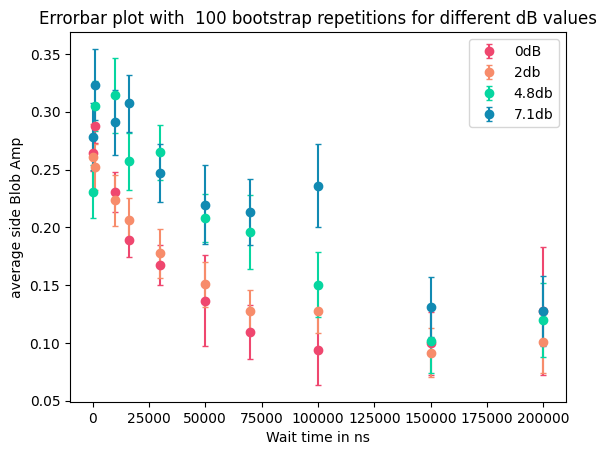

In [18]:
plt.errorbar(decay_times[:], cat_blob_amps_averaged[:],yerr=cat_error_bars,fmt= 'o', label = '0dB', capsize = 2, color = '#ef476f',)
plt.errorbar(decay_times[:], db3_blob_amps_averaged[:],yerr=db3_error_bars,fmt= 'o', label = '2db', capsize = 2, color = '#f78c6b')
plt.errorbar(decay_times[:], db6_blob_amps_averaged[:],yerr=db6_error_bars,fmt= 'o', label = '4.8db', capsize = 2, color = '#06d6a0')
plt.legend()
plt.errorbar(decay_times[:], db7_blob_amps_averaged[:],yerr=db7_error_bars,fmt= 'o', label = '7.1db', capsize = 2, color = '#118ab2')
plt.legend()
plt.title(f'Errorbar plot with  100 bootstrap repetitions for different dB values')
plt.xlabel('Wait time in ns')
plt.ylabel("average side Blob Amp")

In [22]:
import numpy as np
cat_blob_amps = np.array([cat_blob_amps_averaged, db3_blob_amps_averaged, db6_blob_amps_averaged, db7_blob_amps_averaged ])
error_bars = np.array([cat_error_bars, db3_error_bars, db6_error_bars,db7_error_bars])
np.savez('bootstrap_blob_amps.npz', decay_times=decay_times, cat_blob_amps=cat_blob_amps, error_bars = error_bars)

# Setup a few big sweeps

# phyiscal boundary conditions

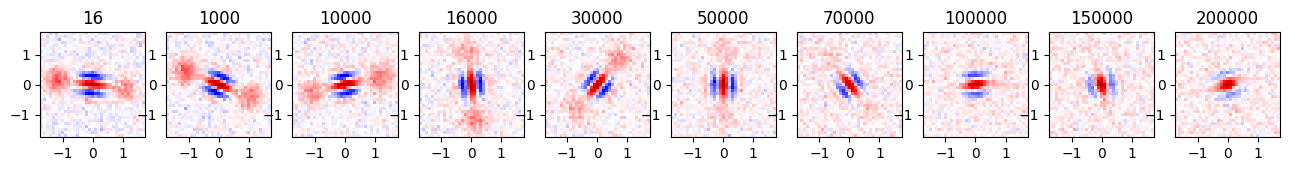

Run Number: 0
Run Number: 1
Run Number: 2
Run Number: 3
Run Number: 4
Run Number: 5
Run Number: 6
Run Number: 7
Run Number: 8
Run Number: 9


c:\Users\jonat\AppData\Local\pypoetry\Cache\virtualenvs\tcsim-vg60nFMD-py3.9\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Run Number: 10
Run Number: 11
Run Number: 12
Run Number: 13
Run Number: 14
Run Number: 15
Run Number: 16
Run Number: 17
Run Number: 18
Run Number: 19
Run Number: 20
Run Number: 21
Run Number: 22
Run Number: 23
Run Number: 24
Run Number: 25
Run Number: 26
Run Number: 27
Run Number: 28
Run Number: 29
Run Number: 30
Run Number: 31
Run Number: 32
Run Number: 33
Run Number: 34
Run Number: 35
Run Number: 36
Run Number: 37
Run Number: 38
Run Number: 39
Run Number: 40
Run Number: 41
Run Number: 42
Run Number: 43
Run Number: 44
Run Number: 45
Run Number: 46
Run Number: 47
Run Number: 48
Run Number: 49
Run Number: 50
Run Number: 51
Run Number: 52
Run Number: 53
Run Number: 54
Run Number: 55
Run Number: 56
Run Number: 57
Run Number: 58
Run Number: 59
Run Number: 60
Run Number: 61
Run Number: 62
Run Number: 63
Run Number: 64
Run Number: 65
Run Number: 66
Run Number: 67
Run Number: 68
Run Number: 69
Run Number: 70
Run Number: 71
Run Number: 72
Run Number: 73
Run Number: 74
Run Number: 75
Run Number

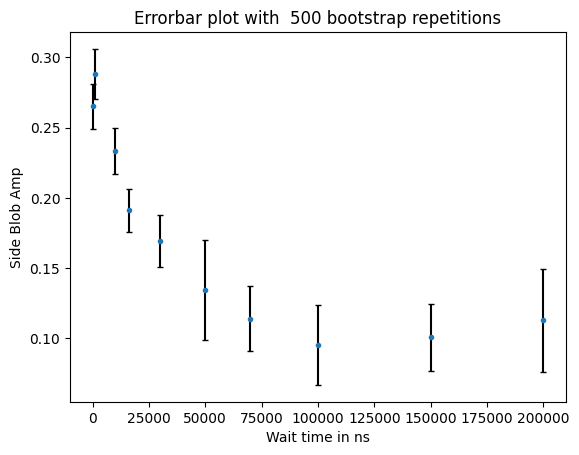

In [64]:
reps = 500


path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data/"
file_end = 'cat_decay.h5'
dd, decay_times, x, y = load_data_no_average(path, file_end)

amp1 = 0.4
sigma1 = 1
cen1 = -3.6
amp2 = 0.8
sigma2 = 1
cen2 = 0
amp3 = 0.4
cen3 = 3.6
sigma3 = 1      
initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
angles = [1.68, 1.96, 1.35, 3.02, 0.68, 3.16, 2.465, 1.47, 2.97, 1.16]

bounds =([0, -5, 0.2 ,0, -0.5, 0.5 ,0,2.5, 0.2],
[0.5, 5, 1 ,1, 0.5, 1.5 ,0.5, 5, 1])


for i in range(1):
    cat_blob_amps, cat_blob_angle = extract_blob_amplitudes_bootstrap(dd, decay_times, x, y, reps, p0_angles=angles, initial_guess_3gaussian=initial_guess, plot=False, bounds=bounds)

    cat_blob_amps_averaged , cat_error_bars = find_averaged_amps_and_errorbars(decay_times, cat_blob_amps, cat_blob_angle)

    plt.errorbar(decay_times[:], cat_blob_amps_averaged[:],yerr=cat_error_bars[:],fmt= '.', ecolor = 'k', capsize = 2)
    plt.title(f'Errorbar plot with  {reps} bootstrap repetitions')
    plt.xlabel('Wait time in ns')
    plt.ylabel("Side Blob Amp")

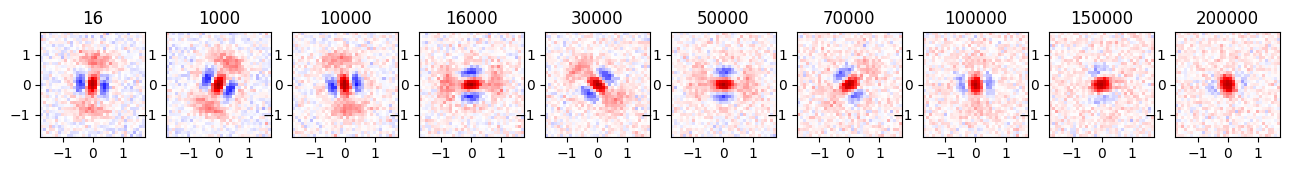

Run Number: 0
Run Number: 1
Run Number: 2
Run Number: 3
Run Number: 4
Run Number: 5
Run Number: 6
Run Number: 7
Run Number: 8
Run Number: 9
Run Number: 10
Run Number: 11
Run Number: 12
Run Number: 13
Run Number: 14
Run Number: 15
Run Number: 16
Run Number: 17
Run Number: 18
Run Number: 19
Run Number: 20
Run Number: 21
Run Number: 22
Run Number: 23
Run Number: 24
Run Number: 25
Run Number: 26
Run Number: 27
Run Number: 28
Run Number: 29
Run Number: 30
Run Number: 31
Run Number: 32
Run Number: 33
Run Number: 34
Run Number: 35
Run Number: 36
Run Number: 37
Run Number: 38
Run Number: 39
Run Number: 40
Run Number: 41
Run Number: 42
Run Number: 43
Run Number: 44
Run Number: 45
Run Number: 46
Run Number: 47
Run Number: 48
Run Number: 49
Run Number: 50
Run Number: 51
Run Number: 52
Run Number: 53
Run Number: 54
Run Number: 55
Run Number: 56
Run Number: 57
Run Number: 58
Run Number: 59
Run Number: 60
Run Number: 61
Run Number: 62
Run Number: 63
Run Number: 64
Run Number: 65
Run Number: 66
Run N

c:\Users\jonat\AppData\Local\pypoetry\Cache\virtualenvs\tcsim-vg60nFMD-py3.9\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Run Number: 122
Run Number: 123
Run Number: 124
Run Number: 125
Run Number: 126
Run Number: 127
Run Number: 128
Run Number: 129
Run Number: 130
Run Number: 131
Run Number: 132
Run Number: 133
Run Number: 134
Run Number: 135
Run Number: 136
Run Number: 137
Run Number: 138
Run Number: 139
Run Number: 140
Run Number: 141
Run Number: 142
Run Number: 143
Run Number: 144
Run Number: 145
Run Number: 146
Run Number: 147
Run Number: 148
Run Number: 149
Run Number: 150
Run Number: 151
Run Number: 152
Run Number: 153
Run Number: 154
Run Number: 155
Run Number: 156
Run Number: 157
Run Number: 158
Run Number: 159
Run Number: 160
Run Number: 161
Run Number: 162
Run Number: 163
Run Number: 164
Run Number: 165
Run Number: 166
Run Number: 167
Run Number: 168
Run Number: 169
Run Number: 170
Run Number: 171
Run Number: 172
Run Number: 173
Run Number: 174
Run Number: 175
Run Number: 176
Run Number: 177
Run Number: 178
Run Number: 179
Run Number: 180
Run Number: 181
Run Number: 182
Run Number: 183
Run Numb

Text(0, 0.5, 'Side Blob Amp')

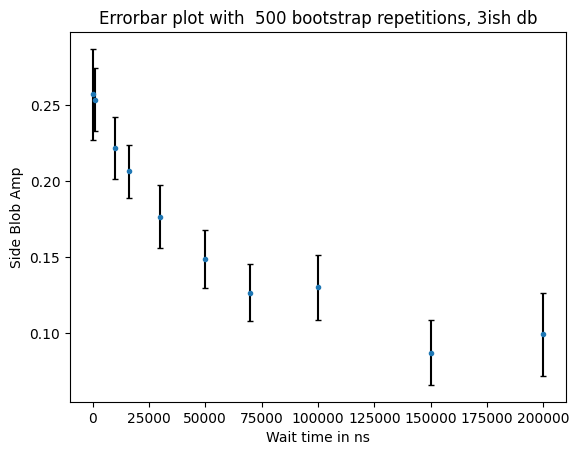

In [68]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data/"
file_end = '3db.h5'
dd, decay_times, x, y = load_data_no_average(path, file_end)

amp1 = 0.4
sigma1 = 0.6
cen1 = -3
amp2 = 0.8
sigma2 = 1
cen2 = 0
amp3 = 0.25
cen3 = 3
sigma3 = 0.6      
initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
angles_3db = [0.14, 3.58, -0.16, 1.54, -0.82, 1.6, 0,-0.04, 1.5, -0.28]


db3_blob_amps, db3_blob_angle = extract_blob_amplitudes_bootstrap(dd, decay_times, x, y, reps, p0_angles=angles_3db, initial_guess_3gaussian=initial_guess, plot=False, bounds=bounds)

db3_blob_amps_averaged , db3_error_bars = find_averaged_amps_and_errorbars(decay_times, db3_blob_amps, db3_blob_angle)

plt.errorbar(decay_times[:], db3_blob_amps_averaged[:],yerr=db3_error_bars,fmt= '.', ecolor = 'k', capsize = 2)
plt.title(f'Errorbar plot with  {reps} bootstrap repetitions, 3ish db')
plt.xlabel('Wait time in ns')
plt.ylabel("Side Blob Amp")


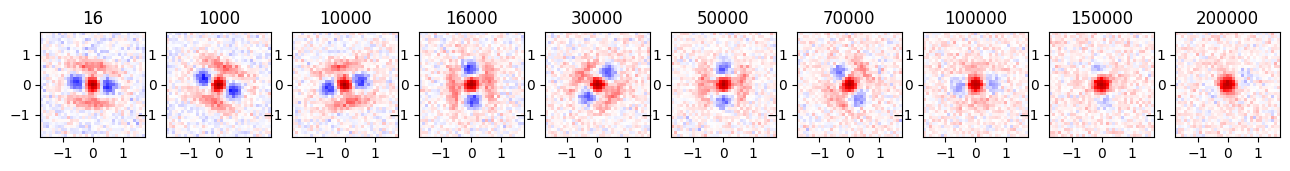

Run Number: 0
Run Number: 1
Run Number: 2
Run Number: 3
Run Number: 4
Run Number: 5
Run Number: 6
Run Number: 7
Run Number: 8
Run Number: 9
Run Number: 10
Run Number: 11
Run Number: 12
Run Number: 13
Run Number: 14
Run Number: 15
Run Number: 16
Run Number: 17
Run Number: 18
Run Number: 19
Run Number: 20
Run Number: 21
Run Number: 22
Run Number: 23
Run Number: 24
Run Number: 25
Run Number: 26
Run Number: 27
Run Number: 28
Run Number: 29
Run Number: 30
Run Number: 31
Run Number: 32
Run Number: 33
Run Number: 34
Run Number: 35
Run Number: 36
Run Number: 37
Run Number: 38
Run Number: 39
Run Number: 40
Run Number: 41
Run Number: 42
Run Number: 43
Run Number: 44
Run Number: 45
Run Number: 46
Run Number: 47
Run Number: 48
Run Number: 49
Run Number: 50
Run Number: 51
Run Number: 52
Run Number: 53
Run Number: 54
Run Number: 55
Run Number: 56
Run Number: 57
Run Number: 58
Run Number: 59
Run Number: 60
Run Number: 61
Run Number: 62
Run Number: 63
Run Number: 64
Run Number: 65
Run Number: 66
Run N

Text(0, 0.5, 'Side Blob Amp')

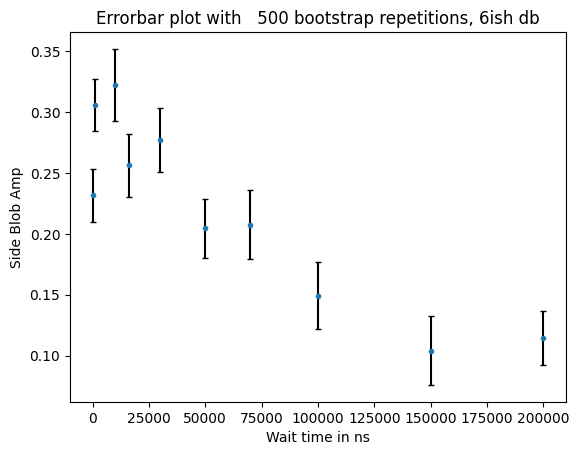

In [69]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data/"
file_end = '6db.h5'
dd, decay_times, x, y = load_data_no_average(path, file_end)

bounds =([0, -5, 0.2 ,0, -0.5, 0.5 ,0,0, 0.2],
[0.5, 0, 1 ,1, 0.5, 1.5 ,0.5, 5, 1])
amp1 = 0.4
sigma1 = 0.45
cen1 = -2.1
amp2 = 0.8
sigma2 = 1
cen2 = 0
amp3 = 0.4
cen3 = 2.1
sigma3 = 0.45      
initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
angles_6db = [0.09, 0.36, -0.27, 1.41, -0.91, 1.5, 0.863, -0.1, 1.32, -0.43]

db6_blob_amps, db6_blob_angle = extract_blob_amplitudes_bootstrap(dd, decay_times, x, y, reps, p0_angles=angles_6db, initial_guess_3gaussian=initial_guess, plot=False, bounds=bounds)

db6_blob_amps_averaged , db6_error_bars = find_averaged_amps_and_errorbars(decay_times, db6_blob_amps, db6_blob_angle)

plt.errorbar(decay_times[:], db6_blob_amps_averaged[:],yerr=db6_error_bars,fmt= '.', ecolor = 'k', capsize = 2)
plt.title(f'Errorbar plot with   {reps} bootstrap repetitions, 6ish db')
plt.xlabel('Wait time in ns')
plt.ylabel("Side Blob Amp")


In [2]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data/"
file_end = '7db.h5'
dd, decay_times, x, y = load_data_no_average(path, file_end)

amp1 = 0.4
sigma1 = 0.32
cen1 = -1.5
amp2 = 0.8
sigma2 = 0.4
cen2 = 0
amp3 = 0.4
cen3 = 1.5
sigma3 = 0.32     
initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
angles_7db = [0.06, 0.37, -0.254, 1.40, -0.91, 1.50, 0.83, -0.1, 1.37, -0.293]
bounds =([0, -5, 0.2 ,0, -0.5, 0 ,0,0, 0.2],
[0.5, 0, 1 ,1, 0.5, 1 ,0.5, 5, 1])


db7_blob_amps, db7_blob_angle = extract_blob_amplitudes_bootstrap(dd, decay_times, x, y, 200, p0_angles=angles_7db, initial_guess_3gaussian=initial_guess, plot=False, bounds=bounds)

db7_blob_amps_averaged , db7_error_bars = find_averaged_amps_and_errorbars(decay_times, db7_blob_amps, db7_blob_angle)

plt.errorbar(decay_times[:], db7_blob_amps_averaged[:],yerr=db7_error_bars,fmt= '.', ecolor = 'k', capsize = 2)
plt.title(f'Errorbar plot with  {reps} bootstrap repetitions, 7ish db')
plt.xlabel('Wait time in ns')
plt.ylabel("Side Blob Amp")


NameError: name 'load_data_no_average' is not defined

Text(0, 0.5, 'average side Blob Amp')

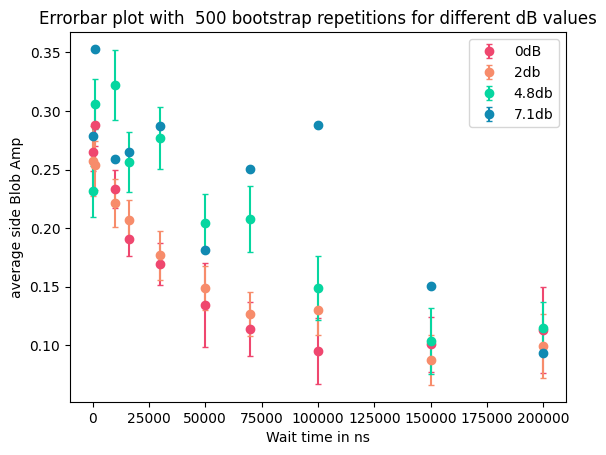

In [84]:
plt.errorbar(decay_times[:], cat_blob_amps_averaged[:],yerr=cat_error_bars,fmt= 'o', label = '0dB', capsize = 2, color = '#ef476f',)
plt.errorbar(decay_times[:], db3_blob_amps_averaged[:],yerr=db3_error_bars,fmt= 'o', label = '2db', capsize = 2, color = '#f78c6b')
plt.errorbar(decay_times[:], db6_blob_amps_averaged[:],yerr=db6_error_bars,fmt= 'o', label = '4.8db', capsize = 2, color = '#06d6a0')
plt.legend()
plt.errorbar(decay_times[:], db7_blob_amps_averaged[:],yerr=db7_error_bars,fmt= 'o', label = '7.1db', capsize = 2, color = '#118ab2')
plt.legend()
plt.title(f'Errorbar plot with  {reps} bootstrap repetitions for different dB values')
plt.xlabel('Wait time in ns')
plt.ylabel("average side Blob Amp")